
# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch
import tmol.score.ljlk.jit_score_graph
import tmol.score.ljlk.cpp_potential

In [6]:
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [7]:
import toolz

In [8]:
decoys = tmol.tests.data.structures_bysize()

In [28]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame, stat_profile

torch.set_num_threads(1)

rosetta_score_results = []
scores = {}
profiles = {}

for dsize, d in decoys.items():
    model_name = f"BYSIZE_{dsize}"

    work_pose = d.stripped_pose.pose

    logging.info(dsize)

    fixture = make_fixture(
        "score",
        rosetta_score_results.append,
        nres=len(work_pose.residues),
        natoms=len(d.tmol_coords),
        model=model_name,
        max_time=.25,
        use_cprofile=True,
        
    )

    logging.info("Rosetta")
    atr_rep_sf = pyrosetta.get_score_function()
    for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        if k not in ("fa_atr", "fa_rep"):
            atr_rep_sf.set_weight(v, 0)

    @subfixture(fixture, impl="rosetta", device="cpu")
    def rosetta_atr_rep():
        work_pose.energies().clear()
        return atr_rep_sf(work_pose)
    
    @reactive_attrs
    class TMolJitLJLK(
        tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
        tmol.score.coordinates.CartesianAtomicCoordinateProvider,
        tmol.score.bonded_atom.BondedAtomScoreGraph,
        tmol.score.device.TorchDevice,
    ):
        pass

    score_graphs = dict(
        tmol_lj_cpu_cpp=TMolJitLJLK.build_for(
            d.tmol_system, requires_grad=False, lj_jit_type="cpp"
        )
    )

    for n, sg in score_graphs.items():
        logging.info(f"{n}")
        # Setup graph
        sg.intra_score().total_lj

        for ptype in tmol.score.ljlk.cpp_potential.potentials:
            tmol.score.ljlk.cpp_potential.POTENTIAL_SET = ptype

            gfix = make_subfixture(
                fixture, f".{n}.{ptype}", impl=ptype, device=sg.device.type
            )

            @gfix
            def benchmark_score_graph():
                sg.coords = sg.coords
                return sg.intra_score().total_lj

            scores.setdefault(model_name, {})[gfix.name] = benchmark_score_graph

    del score_graphs
    torch.cuda.empty_cache()

    tmol_scores = " ".join(f"{n}: {v}" for n, v in scores[model_name].items())

    logging.info(f"rosetta: {rosetta_atr_rep} {tmol_scores}")


INFO:root:100
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -440.40303847870354 score.tmol_lj_cpu_cpp.blocked: tensor([-370.7063]) score.tmol_lj_cpu_cpp.naive: tensor([-370.7062])
INFO:root:150
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -752.441272221159 score.tmol_lj_cpu_cpp.blocked: tensor([-353.4838]) score.tmol_lj_cpu_cpp.naive: tensor([-353.4837])
INFO:root:40
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -174.25545026564072 score.tmol_lj_cpu_cpp.blocked: tensor([-152.2725]) score.tmol_lj_cpu_cpp.naive: tensor([-152.2725])
INFO:root:75
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -291.7034003587354 score.tmol_lj_cpu_cpp.blocked: tensor([430.5978]) score.tmol_lj_cpu_cpp.naive: tensor([430.5983])
INFO:root:55
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -159.61986092225598 score.tmol_lj_cpu_cpp.blocked: tensor([-32.8630]) score.tmol_lj_cpu_cpp.naive: tensor([-32.8630])
INFO:root:15
INFO:root:Ro

In [43]:
import operator
def sum(v):
    return toolz.reduce(operator.add, v)

In [34]:
import pandas

In [35]:
import altair
altair.themes.register("vis", lambda: dict(config={
        "view": {"height": 500, "width": 800},
        "axis": {"labelFontSize": 16, "titleFontSize": 16},
        "legend": {"labelFontSize": 16, "titleFontSize": 16},
        "header": {"labelFontSize": 16, "titleFontSize": 16},
        "title": {"fontSize": 16},
    }))
altair.themes.enable("vis")
altair.data_transformers.enable('default', max_rows=20e3)

pass

/scratch/USERS/fordas/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/scratch/USERS/fordas/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


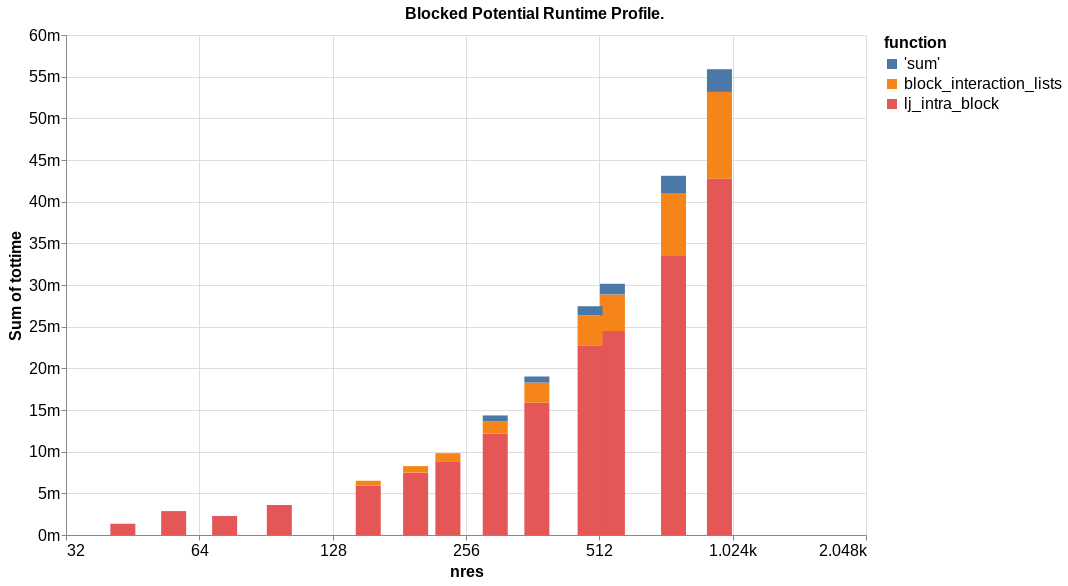

In [36]:
pdat = stat_profile(rosetta_score_results)
pdat = pdat.query("impl != 'rosetta'").query("impl == 'blocked'")
rdat = pdat.query("tottime > 500e-6 and fractime > 1e-3")
rdat["function"] = (
    rdat.function_name.str.extract("method (['\.\w]*)")
    .where(lambda v: ~pandas.isna(v), rdat.function_name)
    .map(lambda v: v.split(".")[-1])
)

encoding = dict(
    x=altair.X(
        "nres", axis=altair.Axis(format="s"), scale=altair.Scale(type="log", base=2)
    ),
    y=altair.Y("sum(tottime)", axis=altair.Axis(format="s")),
    color="function",
)

c = (altair.Chart(rdat).mark_bar().encode(**encoding)).configure(
    bar={"continuousBandSize": 25}
)
c.title = "Blocked Potential Runtime Profile."
c


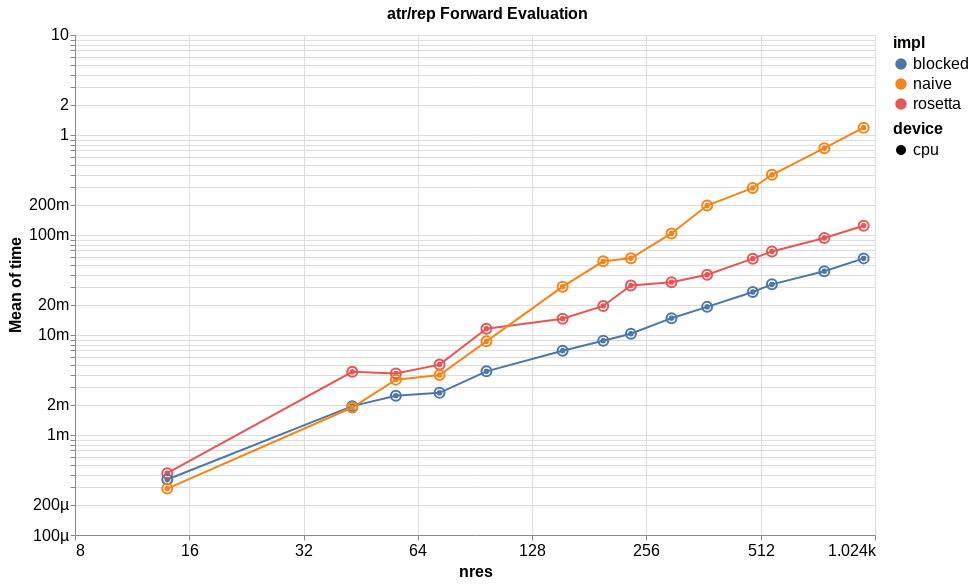

In [47]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'")
            .groupby("model")
            .time.mean()
            .rename("rosetta_mean")
            .to_frame(),
            left_on="model",
            right_index=True,
        )
        .eval("time / rosetta_mean")
        .rename("rosetta_relative"),
    ),
    axis=1,
)

encoding = dict(
    x=altair.X(
        "nres", axis=altair.Axis(format="s"), scale=altair.Scale(type="log", base=2)
    ),
    y=altair.Y(
        "mean(time)",
        scale=altair.Scale(type="log", base=10),
        axis=altair.Axis(format="s"),
    ),
    color="impl",
    shape="device",
)

sum(
    (
        altair.Chart(dat, title="atr/rep Forward Evaluation")
        .mark_line()
        .encode(**encoding),
        altair.Chart(dat).mark_point(size=100).encode(**encoding)
    )
)


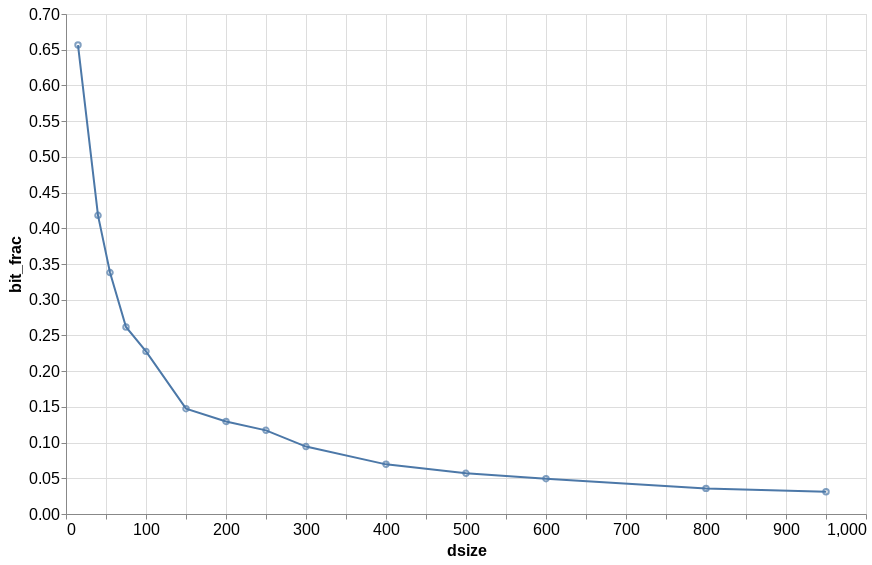

In [48]:
rec = []
for dsize, d in decoys.items():
    bit = tmol.score.ljlk.cpp_potential.cpu.block_interaction_lists(d.tmol_coords, 6.0, 8)
    bit_frac = float(bit.shape[0]) / (d.tmol_coords.shape[0] / 8) ** 2
    rec.append(dict(dsize=dsize, bit_frac=bit_frac))

c = altair.Chart(pandas.DataFrame.from_records(rec))

sum([c.mark_line().encode(x="dsize", y="bit_frac"), c.mark_point().encode(x="dsize", y="bit_frac")])

In [49]:
display((
    dat.query("name=='score.rosetta_atr_rep'")
    .groupby("nres")[["time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

display((dat
    .groupby(("nres", "name"))[["rosetta_relative", "time"]]
    .describe()
    .reorder_levels((1, 0), axis=1)["mean"]
    .xs("score.tmol_lj_cpu_cpp.blocked", level=1)
    .eval("fold_acceleration = rosetta_relative ** -1")
))

,mean,max,std
,time,time,time
nres,,,
14,0.000415,0.000653,0.000054
43,0.004287,0.007296,0.000601
56,0.004117,0.006306,0.000522
73,0.005058,0.006473,0.000278
97,0.011554,0.012805,0.001493
154,0.014568,0.014763,0.000151
197,0.019519,0.019888,0.000152
233,0.031247,0.033439,0.004000


,rosetta_relative,time,fold_acceleration
nres,,,
14,0.865164,0.000359,1.155850
43,0.453479,0.001944,2.205171
56,0.600381,0.002472,1.665609
73,0.522258,0.002641,1.914762
97,0.374898,0.004331,2.667391
154,0.478069,0.006965,2.091747
197,0.449490,0.008774,2.224744
233,0.329477,0.010295,3.035115
298,0.436551,0.014729,2.290684
